# Import Model

In [ ]:
import torch
import torch.nn as nn
import torch
from torch import nn
from torch.autograd import Function


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()

class NeighborSubtileEncoder(nn.Module):
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
    
class SharedDecoder(nn.Module):
    def __init__(self, tile_size=26):
        super().__init__()
        self.tile_size = tile_size
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(1, 32, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.SiLU(),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, full_output: bool = False):
        B = x.size(0)
        patches = x.contiguous().reshape(B, 9, 1, 8, 8)
        patches = patches.contiguous().reshape(B*9, 1, 8, 8)
        recon = self.deconv(patches)
        _, C, H, W = recon.shape
        h0 = (H - self.tile_size)//2
        w0 = (W - self.tile_size)//2
        recon = recon[:, :, h0:h0+self.tile_size, w0:w0+self.tile_size]
        recon = recon.contiguous().reshape(B, 9, C, self.tile_size, self.tile_size)
        return recon if full_output else recon[:,4]


# ——— 在 AE_Center/AE_AllSubtiles/AE_MaskedMAE 中使用这个 decoder ———
# AE_Center 只输出中心 patch
class AE_Center(nn.Module):
    def __init__(self, tile_dim = 64 , center_dim=64, neighbor_dim=64, hidden_dim=128, tile_size=26):
        super().__init__()
        self.enc_center = CenterSubtileEncoder(center_dim)
        self.enc_neigh  = NeighborSubtileEncoder(neighbor_dim)
        self.enc_tile  = DeepTileEncoder(tile_dim)
        fusion_dim = center_dim + neighbor_dim + tile_dim
        self.fc_enc = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
        )
        self.fc_dec = nn.Linear(hidden_dim, 9*1*8*8)
        self.decoder = SharedDecoder(tile_size)
    def forward(self, tile, subtiles):
        f_c = self.enc_center(subtiles[:,4])
        f_n = self.enc_neigh(subtiles)
        f_t = self.enc_tile(tile)
        fused = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
        h = self.fc_enc(fused)
        x = self.fc_dec(h)
        return self.decoder(x)

# 修改后的 AE_AllSubtiles，AE_MaskedMAE 及 PretrainedEncoderRegressor，实现输入强制 contiguous 并移除所有 view
class AE_AllSubtiles(nn.Module):
    def __init__(self, tile_dim=64, center_dim=64, neighbor_dim=64, hidden_dim=128, tile_size=26):
        super().__init__()
        self.enc_center = CenterSubtileEncoder(center_dim)
        self.enc_neigh  = NeighborSubtileEncoder(neighbor_dim)
        self.enc_tile   = DeepTileEncoder(tile_dim)
        fusion_dim = center_dim + neighbor_dim + tile_dim
        self.fc_enc = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
        )
        self.fc_dec = nn.Linear(hidden_dim, 9 * 1 * 8 * 8)
        self.decoder = SharedDecoder(tile_size=tile_size)

    def forward(self, tile, subtiles):
        tile     = tile.contiguous()
        subtiles = subtiles.contiguous()

        f_c = self.enc_center(subtiles[:, 4])
        f_n = self.enc_neigh(subtiles)
        f_t = self.enc_tile(tile)

        h = self.fc_enc(torch.cat([f_c, f_n, f_t], dim=1).contiguous())
        x = self.fc_dec(h)
        return self.decoder(x, full_output=True)  # [B, 9, 3, tile_size, tile_size]


class AE_MaskedMAE(nn.Module):
    def __init__(self, tile_dim=64, center_dim=64, neighbor_dim=64, hidden_dim=128,
                 tile_size=26, mask_ratio=0.5):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.ae_all = AE_AllSubtiles(tile_dim, center_dim, neighbor_dim, hidden_dim, tile_size)

    def forward(self, tile, subtiles):
        tile     = tile.contiguous()
        subtiles = subtiles.contiguous()
        B = subtiles.size(0)
        # 隨機遮 mask_ratio 的 patches
        mask = (torch.rand(B, 9, 1, 1, 1, device=subtiles.device) > self.mask_ratio).float()
        masked = subtiles * mask
        return self.ae_all(tile, masked)

model = AE_Center(center_dim=64, neighbor_dim=64, hidden_dim=128, tile_size=26)
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")

Params: 5.38M


In [38]:
# ---------- 梯度反转层  ----------
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd=1.0):
    return GradReverse.apply(x, lambd)


# ---------- 多级 Domain‐clf 的 Neighbor 编码器 ----------
class NeighborSubtileEncoder_DANN(nn.Module):
    """
    在 layer1/layer2 后分别插入一个 domain‐clf head，
    可以对不同深度的特征都做域对齐。
    """
    def __init__(self, out_dim, n_domains, in_channels=3):
        super().__init__()
        # 原始卷积 + Pool
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.SiLU(), nn.MaxPool2d(2)
        )  # 26 → 13

        # 第一块 residual + pool
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64), nn.MaxPool2d(2)
        )  # 13 → 6
        # 第二块 residual
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128)
        )  # 6 × 6

        # 多尺度池化 + 全连接（原样）
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool  = nn.AdaptiveAvgPool2d((3,3))
        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.SiLU(),
        )

        # —— 多级域分类头 —— 
        # layer1 输出 channel=64, 我们先 global‐avg 然后小 MLP
        self.dom1 = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, n_domains)
        )
        # layer2 输出 channel=128
        self.dom2 = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, n_domains)
        )

    def forward(self, subtiles, grl_lambda):
        """
        subtiles: Tensor of shape (B, 9, C, H, W)
        grl_lambda: float, gradient‐reverse strength
        """
        B, N, C, H, W = subtiles.shape
        x = subtiles.view(B*N, C, H, W)  # (B*9, C, H, W)

        # layer0
        x0 = self.layer0(x)              # (B*9, 32, 13,13)

        # layer1
        x1 = self.layer1(x0)             # (B*9, 64, 6,6)
        # 平均池化到 (B*9,64), 再 reshape(B,9,64) → mean over 9 subtiles → (B,64)
        v1 = x1.view(B, N, 64, x1.size(-2), x1.size(-1)).mean(dim=1).mean([-2,-1])
        # GRL + domain logit
        d1 = self.dom1(grad_reverse(v1, grl_lambda))

        # layer2
        x2 = self.layer2(x1)             # (B*9,128,6,6)
        v2 = x2.view(B, N, 128, x2.size(-2), x2.size(-1)).mean(dim=1).mean([-2,-1])
        d2 = self.dom2(grad_reverse(v2, grl_lambda))

        # 多尺度池化 + fc → 最终特征 out_dim
        # global / mid / large on x2
        g = self.global_pool(x2).view(B, N, -1).mean(dim=1)
        m = self.mid_pool(x2).view(B, N, -1).mean(dim=1)
        l = self.large_pool(x2).view(B, N, -1).mean(dim=1)

        feat = self.fc(torch.cat([g, m, l], dim=1))  # (B, out_dim)

        # 返回主干特征 + 两级 domain_logits
        return feat, [d1, d2]
    
    
class CenterSubtileEncoder_DANN(nn.Module):
    def __init__(self, out_dim, n_domains, in_channels=3):
        super().__init__()
        # 原来的 conv / pool 层
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.SiLU(), nn.MaxPool2d(2)
        )
        # 第一块残差 + pool
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64), nn.MaxPool2d(2)
        )
        # 第二块残差
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128)
        )

        # 多尺度池化 + fc（保持原样）
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool  = nn.AdaptiveAvgPool2d((3,3))
        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.SiLU(),
        )

        # ——— 多级 domain heads ———
        # 注意我们要 GRL，再接一个小 MLP → n_domains
        self.dom1 = nn.Sequential(
            # from layer1 输出的通道数 64
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, n_domains)
        )
        self.dom2 = nn.Sequential(
            # from layer2 输出的通道数 128
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, n_domains)
        )

    def forward(self, x, grl_lambda):
        # layer0
        x0 = self.layer0(x)     # (B,32,13,13)

        # layer1
        x1 = self.layer1(x0)    # (B,64,6,6)
        # global‐pool 再 Linear → domain logits
        v1 = x1.mean([-2,-1])   # (B,64)
        d1 = self.dom1(grad_reverse(v1, grl_lambda))

        # layer2
        x2 = self.layer2(x1)    # (B,128,6,6)
        v2 = x2.mean([-2,-1])   # (B,128)
        d2 = self.dom2(grad_reverse(v2, grl_lambda))

        # 最后的多尺度汇聚
        g = self.global_pool(x2).view(x2.size(0), -1)
        m = self.mid_pool(x2).view(x2.size(0), -1)
        l = self.large_pool(x2).view(x2.size(0), -1)
        feat = self.fc(torch.cat([g, m, l], dim=1))

        return feat, [d1, d2]
    

class DANN_AE_MultiLevel(nn.Module):
    """
    Multi‐Level DANN on top of AE_Center and AE_AllSubtiles.
    - 三条对抗支路：center‐level, neighbor‐level, fusion‐level
    - 每条支路都经过 GRL，再做 n_domains 分类
    - 重建分支仍然只做 center patch 重建
    """
    def __init__(self,
                 ae_center:    AE_Center,
                 ae_neigh:     AE_AllSubtiles,
                 hidden_dim:   int = 128,
                 n_domains:    int = 7,
                 center_dim:   int = 64,   # <--- 传入中心 encoder 输出维度
                 neigh_dim:    int = 64    # <--- 传入邻居 encoder 输出维度
    ):
        super().__init__()

        # —— ① 拿编码器部分（不加载 decoder） —— 
        self.enc_center = ae_center.enc_center   # 中心 patch encoder
        self.enc_neigh  = ae_center.enc_neigh    # 邻居 patch encoder
        self.fc_enc     = ae_center.fc_enc       # fuse -> latent
        self.fc_dec     = ae_center.fc_dec       # latent -> pre‐decoder
        self.decoder    = ae_center.decoder      # 反卷积 decoder

        # —— ② 多级域分类头 —— 
        # center‐level
        self.dom_center = nn.Sequential(
            nn.Linear(center_dim, center_dim // 2),
            nn.ReLU(),
            nn.Linear(center_dim // 2, n_domains)
        )
        # neighbor‐level
        self.dom_neigh = nn.Sequential(
            nn.Linear(neigh_dim, neigh_dim // 2),
            nn.ReLU(),
            nn.Linear(neigh_dim // 2, n_domains)
        )
        # fusion‐level
        self.dom_fusion = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_domains)
        )

        self.grl_lambda = 1.0

    def forward(self, tile, subtiles):
        # ——— 1) 中心 / 邻居 编码 ———
        f_c = self.enc_center(subtiles[:,4])   # (B, center_dim)
        f_n = self.enc_neigh(subtiles)          # (B, neigh_dim)

        # ——— 2) 多级 对抗支路 ———
        dc = self.dom_center(grad_reverse(f_c, self.grl_lambda))    # (B, n_domains)
        dn = self.dom_neigh (grad_reverse(f_n, self.grl_lambda))    # (B, n_domains)

        # ——— 3) 融合 & latent ———
        fuse = torch.cat([f_c, f_n], dim=1)      # (B, center_dim+neigh_dim)
        h    = self.fc_enc(fuse)                 # (B, hidden_dim)
        df   = self.dom_fusion(                   # (B, n_domains)
                 grad_reverse(h, self.grl_lambda)
             )

        # ——— 4) 重建分支 ———
        x     = self.fc_dec(h)
        recon = self.decoder(x)                   # (B,3,26,26) 仅重建中心 patch

        # 三个 level 的 logits 列表返回
        return recon, [dc, dn, df]
# 先 load 好 AE_Center 和 AE_AllSubtiles
ae_center = AE_Center(center_dim=64, neighbor_dim=64, hidden_dim=128, tile_size=26)
ae_center.load_state_dict(torch.load("AE_model/version1/AE_Center_noaug/best.pt"))

ae_all    = AE_AllSubtiles(center_dim=64, neighbor_dim=64, hidden_dim=128, tile_size=26)
ae_all.load_state_dict(torch.load("AE_model/version1/AE_All_noaug/best.pt"))

# 构造 DANN_AE_MultiLevel
model = AE_Center(

)
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77356/3420496107.py:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_center.load_state_dict(torch.load("AE_mo

Params: 1.17M


## Load Model

# Import training data

## Same in multiple .pt

In [2]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:287: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

Loaded keys: dict_keys(['tile', 'source_idx', 'label', 'subtiles', 'slide_idx'])
Samples: 8348


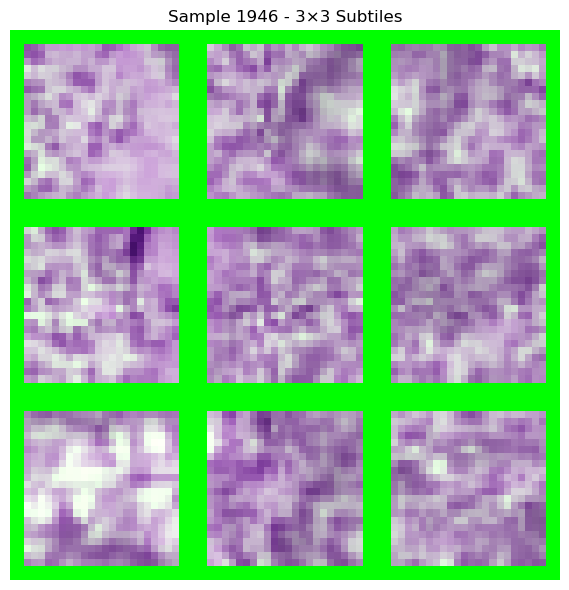

In [6]:
from python_scripts.validate_input import visualize_random_from_grouped_data

visualize_random_from_grouped_data(grouped_data, subtile_grid_size=3)

In [7]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) 补 slide_idx，全都标为 "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


In [8]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs



image_keys = [ 'tile', 'subtiles']


# 用法示例
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)


# 把 test_data_dict 里所有 ndarray / tensor 都转成 list
for key, val in test_dataset.items():
    print(key, type(val))
    # 如果是 torch.Tensor
    if isinstance(val, torch.Tensor):
        test_dataset[key] = val.cpu().tolist()
    # 如果是 numpy.ndarray
    elif isinstance(val, np.ndarray):
        test_dataset[key] = val.tolist()
    # 否则留着（比如 slide_idx 本身就是 list）

# 然后统一用 list + list
combined = {}
for key, train_vals in test_dataset.items():
    if key in test_dataset:
        combined[key] = train_vals + grouped_data[key]
    else:
        combined[key] = train_vals


# 1) 先找出所有 unique slide name 并排个序
unique_slides = sorted(set(combined['slide_idx']))  
# e.g. ['S_1','S_2',...,'S_7']

# 2) 建立一个映射：
slide2id = {name: i for i, name in enumerate(unique_slides)}
# 如 {'S_1':0, 'S_2':1, ..., 'S_7':6}

# 3) 用它把 combined['slide_idx'] 转成整数列表
combined['slide_idx'] = [ slide2id[s] for s in combined['slide_idx'] ]

# 最后构造 Dataset
image_keys = ['tile','subtiles']
full_dataset = importDataset(
    data_dict   = combined,
    model       = model,
    image_keys  = image_keys,
    transform   = lambda x: x,
    print_sig   = True
)

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_17748/1794571483.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu"

⚠️ 从 'tile' 推断样本数量: 2088
tile <class 'list'>
subtiles <class 'list'>
label <class 'torch.Tensor'>
slide_idx <class 'list'>
Model forward signature: (tile, subtiles)


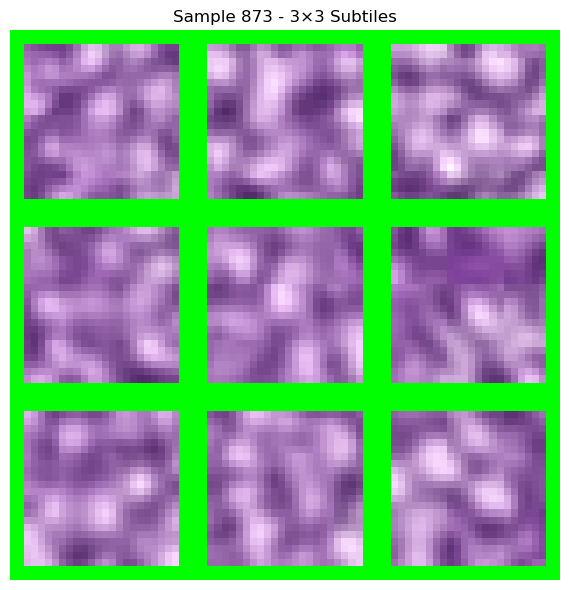

In [10]:
visualize_random_from_grouped_data(test_dataset, subtile_grid_size=3)

In [11]:
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Subset, DataLoader
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
repeats = 1
slide_idxs = []
batch_size = 64
for i in range(len(full_dataset)):
    slide_idxs.append(full_dataset[i]["slide_idx"])  # 或者 "slide_name"

# 做一次 80/20 的 train/val 划分，按 slide 分层
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X=range(len(full_dataset)),
                                     y=[0]*len(full_dataset),
                                     groups=slide_idxs))

all_data = {}
# 取第一个 sample 的 key 列表
sample0 = full_dataset[0]
for key in sample0.keys():
    all_data[key] = [ full_dataset[i][key] for i in range(len(full_dataset)) ]


train_base = subset_grouped_data(all_data, train_idx)
print("Starting importDataset...")

# 1) 原始 dataset
train_ds = importDataset(train_base, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
val_ds     = subset_grouped_data(all_data, val_idx)
val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, num_workers=0, pin_memory=False)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Starting importDataset...
Starting DataLoader...


In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import GroupShuffleSplit
from python_scripts.aug import augment_grouped_data, identity, subset_grouped_data, AugmentFn
from python_scripts.import_data import importDataset
from tqdm import tqdm

def to_channel_last(grouped_data):
    out = {}
    for k,v in grouped_data.items():
        if k == 'tile':
            # [3,H,W] -> [H,W,3]
            out[k] = [ x.permute(1,2,0).cpu().numpy() for x in v ]
        elif k == 'subtiles':
            # [9,3,26,26] -> [9,26,26,3]
            out[k] = [ x.permute(0,2,3,1).cpu().numpy() for x in v ]
        else:
            # 不变：label, slide_idx, 其它 Python 原生类型
            out[k] = v
    return out

import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

class EarlyStopper:
    """简单的 EarlyStopping：若连续 patience 个 epoch 验证 loss 没下降，则停止。"""
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss + self.min_delta < self.best:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


def fit_ae(
    name,
    model: nn.Module,
    train_ld: DataLoader,
    val_ld: DataLoader,
    train_base,               # 用于动态增强时的原始 grouped_data
    repeats: int = 1,
    augment: bool = False,
    batch_size: int = 64,
    epochs: int = 20,
    lr: float = 1e-3,
    patience: int = 10,        # EarlyStopping 的耐心
    factor: float = 0.5,      # LR scheduler 的衰减因子
    min_lr: float = 1e-6,     # LR scheduler 的最小学习率
):
    save_dir = os.path.join("AE_model", name)
    os.makedirs(save_dir, exist_ok=True)

    # 日志文件
    log_path = os.path.join(save_dir, "train_log.csv")
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_mse", "val_mse", "lr"])

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.MSELoss()

    # ReduceLROnPlateau 调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min",
        factor=factor, patience=max(1, patience//2),
        min_lr=min_lr, verbose=True
    )
    stopper = EarlyStopper(patience=patience)

    # 增强函数
    augfn = (lambda gd: augment_grouped_data(
                    grouped_data=gd,
                    image_keys=['tile','subtiles'],
                    repeats=repeats)
             ) if augment else None

    # 准备画布
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    display(fig)

    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        # 如果需要增强，每个 epoch 重建 train loader
        if augment:
            train_base_cl = to_channel_last(train_base)
            aug_data = augfn(train_base_cl)
            train_ds = importDataset(aug_data,
                                     model,
                                     image_keys=['tile','subtiles'],
                                     transform=identity)
            train_ld = DataLoader(train_ds,
                                  batch_size=batch_size,
                                  shuffle=True)

        # ——— 训练 ———
        model.train()
        running = 0.0
        for batch in tqdm(train_ld, desc=f"{name} E{epoch} Train", leave=False):
            tiles, subs = batch['tile'].to(device), batch['subtiles'].to(device)
            subs = subs.contiguous()
            recon = model(tiles, subs)

            target = subs[:,4] if isinstance(model, AE_Center) else subs
            loss = crit(recon, target)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * tiles.size(0)
        train_mse = running / len(train_ld.dataset)
        train_losses.append(train_mse)

        # ——— 验证 ———
        model.eval()
        running = 0.0
        with torch.no_grad():
            for batch in tqdm(val_ld, desc=f"{name} E{epoch} Val", leave=False):
                tiles, subs = batch['tile'].to(device), batch['subtiles'].to(device)
                subs = subs.contiguous()
                recon = model(tiles, subs)
                target = subs[:,4] if isinstance(model, AE_Center) else subs
                running += crit(recon, target).item() * tiles.size(0)
        val_mse = running / len(val_ld.dataset)
        val_losses.append(val_mse)

        # 当前 LR
        current_lr = opt.param_groups[0]['lr']

        # ——— 保存日志 ———
        with open(log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, f"{train_mse:.6f}", f"{val_mse:.6f}", f"{current_lr:.6e}"])

        # ——— 更新调度 & 早停 ———
        scheduler.step(val_mse)
        stopper.step(val_mse)

        # ——— 更新 best ———
        if val_mse < best_val:
            best_val = val_mse
            torch.save(model.state_dict(), os.path.join(save_dir, "best.pt"))

        # ——— 绘制曲线 ———
        clear_output(wait=True)
        ax.clear()
        ax.plot(range(1, epoch+1), train_losses, label="train MSE")
        ax.plot(range(1, epoch+1), val_losses,   label="val   MSE")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MSE")
        ax.set_title(f"{name} Loss (lr={current_lr:.1e})")
        ax.legend()
        display(fig)
        plt.pause(0.1)
        fig.savefig(os.path.join(save_dir, "loss_curve.png"))

        if stopper.should_stop:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    plt.close(fig)

    # 加载最优模型
    model.load_state_dict(torch.load(os.path.join(save_dir, "best.pt")))
    return model


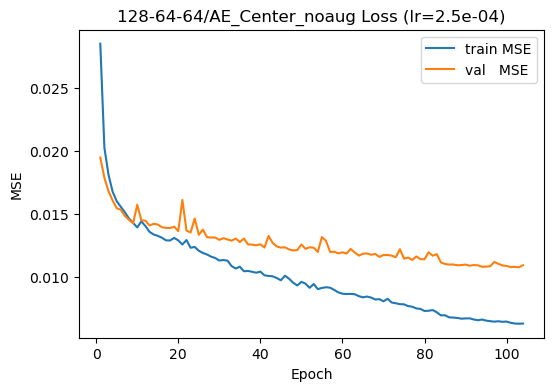

Early stopping at epoch 104 (no improvement for 10 epochs).


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_17748/3759449105.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.jo

In [28]:


# --- 4) 实验配置与执行 ---
# 三种模型与两种增强配置
# ——— configs & 训练调用 ———
configs = [
    ("128-64-64/AE_Center_noaug",  AE_Center(128,64,64,128,26), False),
    # ("128-64-64/AE_Center_aug",    AE_Center(128,64,64,128,26), True),
    # ("128-64-64/AE_All_noaug",     AE_AllSubtiles(128,64,64,128,26), False),
    # ("128-64-64/AE_All_aug",       AE_AllSubtiles(128,64,64,128,26), True),
    # ("128-64-64/AE_Masked_noaug",  AE_MaskedMAE(128,64,64,128,26,mask_ratio=0.5), False),
    # ("128-64-64/AE_Masked_aug",    AE_MaskedMAE(128,64,64,128,26,mask_ratio=0.5), True),
]


for name, ae_model, use_aug in configs:
    print(f"=== Training {name}, augment={use_aug} ===")
    # 每次训练前重置模型参数
    ae_model.apply(lambda m: isinstance(m, nn.Linear) and m.reset_parameters())
    fit_ae(name, ae_model, train_loader, val_loader,train_base =train_base, augment=use_aug, epochs=400, lr=1e-3, repeats=3)


In [ ]:
import os
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 先 import 你的 AE model 定义


# 2) 定义一个小函数：给定 AE 实例，返回所有样本的 latent (N, hidden_dim)
# 2) 通用的“提取 latent 向量”函数
def extract_latents(ae_model, loader, device):
    ae_model.to(device)
    ae_model.eval()

    lat_list = []

    with torch.no_grad():
        for batch in loader:
            tile     = batch['tile'].to(device)          # [B, 3, 78, 78]
            subtiles = batch['subtiles'].to(device)      # [B, 9, 3, 26, 26]
            subtiles = subtiles.contiguous()
            tile     = tile.contiguous()

            if isinstance(ae_model, AE_MaskedMAE):
                real_ae = ae_model.ae_all
            else:
                real_ae = ae_model

            # 分支取出 latent
            f_c = real_ae.enc_center(subtiles[:, 4])         # (B, center_dim)
            f_n = real_ae.enc_neigh(subtiles)                # (B, neighbor_dim)
            f_t = real_ae.enc_tile(tile)                     # (B, tile_dim)

            fused = torch.cat([f_c, f_n, f_t], dim=1)        # (B, fusion_dim)
            h = real_ae.fc_enc(fused)                        # (B, hidden_dim)

            lat_list.append(h.cpu().numpy())

    return np.concatenate(lat_list, axis=0)  # [N, hidden_dim]



# 3) 配置列表，保持和训练时一致
configs = [
    ("128-64-64/AE_Center_noaug",  AE_Center(128,64,64,128,26), False),
    # ("128-64-64/AE_Center_aug",    AE_Center(128,64,64,128,26), True),
    # ("128-64-64/AE_All_noaug",     AE_AllSubtiles(128,64,64,128,26), False),
    # ("128-64-64/AE_All_aug",       AE_AllSubtiles(128,64,64,128,26), True),
    # ("128-64-64/AE_Masked_noaug",  AE_MaskedMAE(128,64,64,128,26,mask_ratio=0.5), False),
    # ("128-64-64/AE_Masked_aug",    AE_MaskedMAE(128,64,64,128,26,mask_ratio=0.5), True),
]


device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# 1) 准备 full_dataset 和一个没有 shuffle 的 DataLoader
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

# 4) 对每个模型依次：
all_latents = {}
for name, ae_model, use_aug in configs:
    ckpt = os.path.join("AE_model", name, "best.pt")
    ae_model.load_state_dict(torch.load(ckpt, map_location=device))
    lat = extract_latents(ae_model, full_loader, device)
    all_latents[name] = lat

    

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_17748/386628652.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(ckpt, map

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


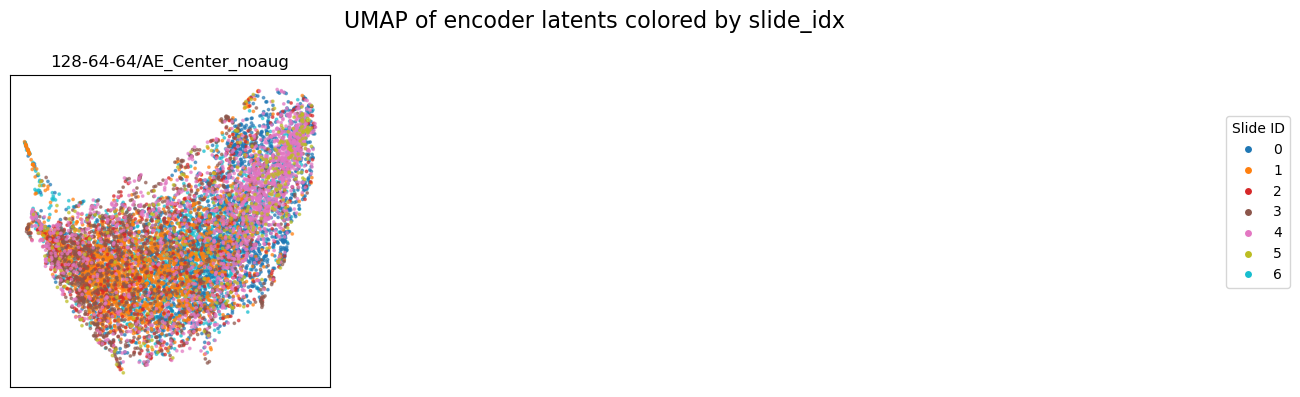

In [30]:
import os
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
# --- 0) 准备 DataLoader 和 slide_idx 列表

slide_idx_list = [ full_dataset[i]['slide_idx'] for i in range(len(full_dataset)) ]
unique_slides  = sorted(set(slide_idx_list))
slide2code     = { s:i for i,s in enumerate(unique_slides) }
codes          = np.array([ slide2code[s] for s in slide_idx_list ])

# --- 1) 按模型提取 latent（同前面 extract_latents 函数）  
# 这里只假设 all_latents 已经是个 dict: {name: np.ndarray of shape (N,hidden_dim)}

# --- 2) UMAP + 子图上色  
n = len(all_latents)
ncols = 3
nrows = int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (name, lat) in zip(axes, all_latents.items()):
    proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42) \
               .fit_transform(lat)          # (N,2)
    sc = ax.scatter(
        proj[:,0], proj[:,1],
        c=codes,
        cmap="tab10",
        s=3, alpha=0.6
    )
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])

# 清掉多余子图
for ax in axes[len(all_latents):]:
    ax.remove()

# 3) 整体图例：Slide → 颜色  
legend_elems = [
    Line2D([0],[0], marker="o", color="w",
           markerfacecolor=sc.cmap(sc.norm(code)),
           markersize=6,
           label=slide)
    for slide,code in slide2code.items()
]
fig.legend(
    handles=legend_elems,
    title="Slide ID",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left"
)

plt.suptitle("UMAP of encoder latents colored by slide_idx", fontsize=16)
plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

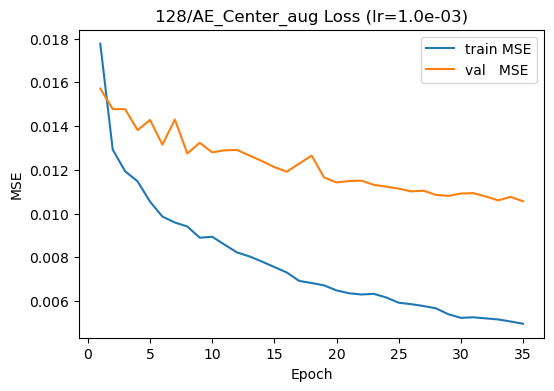

KeyboardInterrupt: 

In [25]:


# --- 4) 实验配置与执行 ---
# 三种模型与两种增强配置
# ——— configs & 训练调用 ———
configs = [
    ("128/AE_Center_noaug",  AE_Center(128,128,128,128,26), False),
    ("128/AE_Center_aug",    AE_Center(128,128,128,128,26), True),
    ("128/AE_All_noaug",     AE_AllSubtiles(128,128,128,128,26), False),
    ("128/AE_All_aug",       AE_AllSubtiles(128,128,128,128,26), True),
    ("128/AE_Masked_noaug",  AE_MaskedMAE(128,128,128,128,26,mask_ratio=0.5), False),
    ("128/AE_Masked_aug",    AE_MaskedMAE(128,128,128,128,26,mask_ratio=0.5), True),
]

for name, ae_model, use_aug in configs:
    print(f"=== Training {name}, augment={use_aug} ===")
    # 每次训练前重置模型参数
    ae_model.apply(lambda m: isinstance(m, nn.Linear) and m.reset_parameters())
    fit_ae(name, ae_model, train_loader, val_loader,train_base =train_base, augment=use_aug, epochs=400, lr=1e-3, repeats=3)


In [26]:

# 3) 配置列表，保持和训练时一致
configs = [
    ("128/AE_Center_noaug",  AE_Center(128,128,128,128,26), False),
    # ("128/AE_Center_aug",    AE_Center(128,128,128,128,26), True),
    # ("128/AE_All_noaug",     AE_AllSubtiles(128,128,128,128,26), False),
    # ("128/AE_All_aug",       AE_AllSubtiles(128,128,128,128,26), True),
    # ("128/AE_Masked_noaug",  AE_MaskedMAE(128,128,128,128,26,mask_ratio=0.5), False),
    # ("128/AE_Masked_aug",    AE_MaskedMAE(128,128,128,128,26,mask_ratio=0.5), True),
]

device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# 1) 准备 full_dataset 和一个没有 shuffle 的 DataLoader
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

# 4) 对每个模型依次：
all_latents = {}
for name, ae_model, use_aug in configs:
    ckpt = os.path.join("AE_model", name, "best.pt")
    ae_model.load_state_dict(torch.load(ckpt, map_location=device))
    lat = extract_latents(ae_model, full_loader, device)
    all_latents[name] = lat

    

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_17748/1683096790.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(ckpt, ma

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


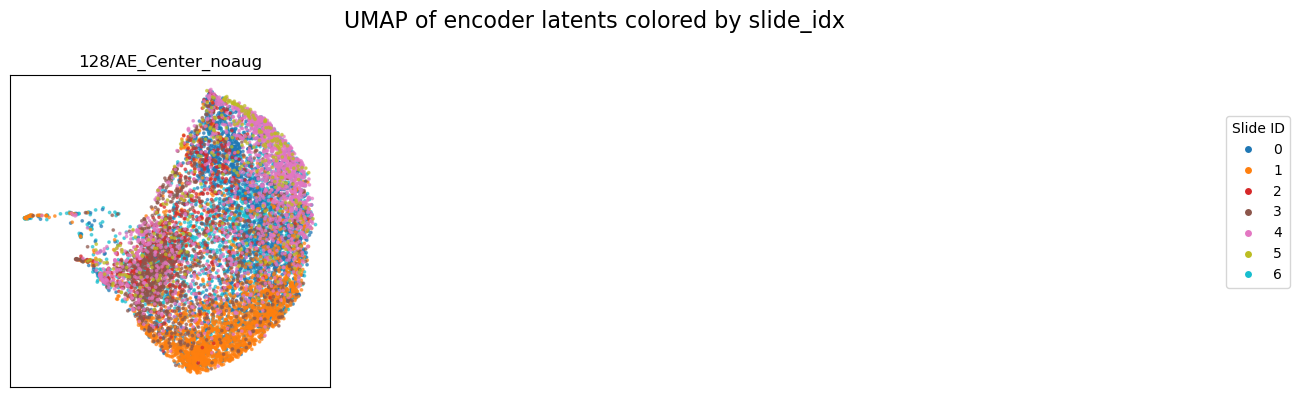

In [27]:
import os
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
# --- 0) 准备 DataLoader 和 slide_idx 列表

slide_idx_list = [ full_dataset[i]['slide_idx'] for i in range(len(full_dataset)) ]
unique_slides  = sorted(set(slide_idx_list))
slide2code     = { s:i for i,s in enumerate(unique_slides) }
codes          = np.array([ slide2code[s] for s in slide_idx_list ])

# --- 1) 按模型提取 latent（同前面 extract_latents 函数）  
# 这里只假设 all_latents 已经是个 dict: {name: np.ndarray of shape (N,hidden_dim)}

# --- 2) UMAP + 子图上色  
n = len(all_latents)
ncols = 3
nrows = int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (name, lat) in zip(axes, all_latents.items()):
    proj = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42) \
               .fit_transform(lat)          # (N,2)
    sc = ax.scatter(
        proj[:,0], proj[:,1],
        c=codes,
        cmap="tab10",
        s=3, alpha=0.6
    )
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])

# 清掉多余子图
for ax in axes[len(all_latents):]:
    ax.remove()

# 3) 整体图例：Slide → 颜色  
legend_elems = [
    Line2D([0],[0], marker="o", color="w",
           markerfacecolor=sc.cmap(sc.norm(code)),
           markersize=6,
           label=slide)
    for slide,code in slide2code.items()
]
fig.legend(
    handles=legend_elems,
    title="Slide ID",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left"
)

plt.suptitle("UMAP of encoder latents colored by slide_idx", fontsize=16)
plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

In [62]:
import torch
import numpy as np
from torch.utils.data import Dataset
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import convert_item
# assume convert_item and get_model_inputs are already defined
# assume convert_item and get_model_inputs are already defined

import torch
import numpy as np
from torch.utils.data import Dataset

# assume convert_item and get_model_inputs are already defined

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        # Check consistent lengths
        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"Field '{key}' length {len(value)} != expected {expected_length}")

        # Ensure forward keys and label exist
        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"Missing required field '{key}' for model forward")
        if 'label' not in self.data:
            raise ValueError("Missing 'label' field in data_dict")

    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        # model inputs
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            if key in self.image_keys:
                tensor = convert_item(value, is_image=True)
            else:
                tensor = convert_item(value, is_image=False)
            sample[key] = tensor.float()

        # label
        label = self.transform(self.data['label'][idx])
        sample['label'] = convert_item(label, is_image=False).float()

                # slide_idx
                # slide_idx as raw
        if 'slide_idx' in self.data:
            sid = self.data['slide_idx'][idx]
            sample['slide_idx'] = sid

        return sample

    def check_item(self, idx=0, num_lines=5):
        # unchanged
        pass



def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
        # 5) 补 slide_idx，全都标为 "S_7"
    out["slide_idx"] = ["S_7"] * dataset_size
    return out


In [79]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs



image_keys = [ 'tile', 'subtiles']


# 用法示例
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/test/hed_normalize_image_masked/test_dataset.pt", model)


# 把 test_data_dict 里所有 ndarray / tensor 都转成 list
for key, val in test_dataset.items():
    print(key, type(val))
    # 如果是 torch.Tensor
    if isinstance(val, torch.Tensor):
        test_dataset[key] = val.cpu().tolist()
    # 如果是 numpy.ndarray
    elif isinstance(val, np.ndarray):
        test_dataset[key] = val.tolist()
    # 否则留着（比如 slide_idx 本身就是 list）

# 然后统一用 list + list
combined = {}
for key, train_vals in test_dataset.items():
    if key in test_dataset:
        combined[key] = train_vals + grouped_data[key]
    else:
        combined[key] = train_vals


# 最后构造 Dataset
image_keys = ['tile','subtiles']
full_dataset = importDataset(
    data_dict   = combined,
    model       = model,
    image_keys  = image_keys,
    transform   = lambda x: x,
    print_sig   = True
)

⚠️ 从 'tile' 推断样本数量: 2088
tile <class 'list'>
subtiles <class 'list'>
label <class 'torch.Tensor'>
slide_idx <class 'list'>
Model forward signature: (tile, subtiles)


In [18]:
# 2) 提取潜在向量 & 对应的 slide_idx
model.eval()
latents = []
slide_ids = []
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

with torch.no_grad():
    for batch in DataLoader(full_dataset, batch_size=64, shuffle=False):
        # 特征部分不变
        tiles    = batch['tile'].to(device)
        subtiles = batch['subtiles'].to(device)

        center   = subtiles[:,4]
        f_c      = model.enc_center(center)
        f_n      = model.enc_neigh(subtiles)
        fuse     = torch.cat([f_c, f_n], dim=1)
        h        = model.fc_enc(fuse)

        latents.append(h.cpu())

        # 这里不要 .numpy()，直接 extend 列表
        sids = batch['slide_idx']   # 这是一个 list
        slide_ids.extend(sids)

# 最后转成 numpy array
latents   = torch.cat(latents, dim=0).numpy()
slide_ids = np.array(slide_ids)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids 已经准备好
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# 自定义图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()



RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

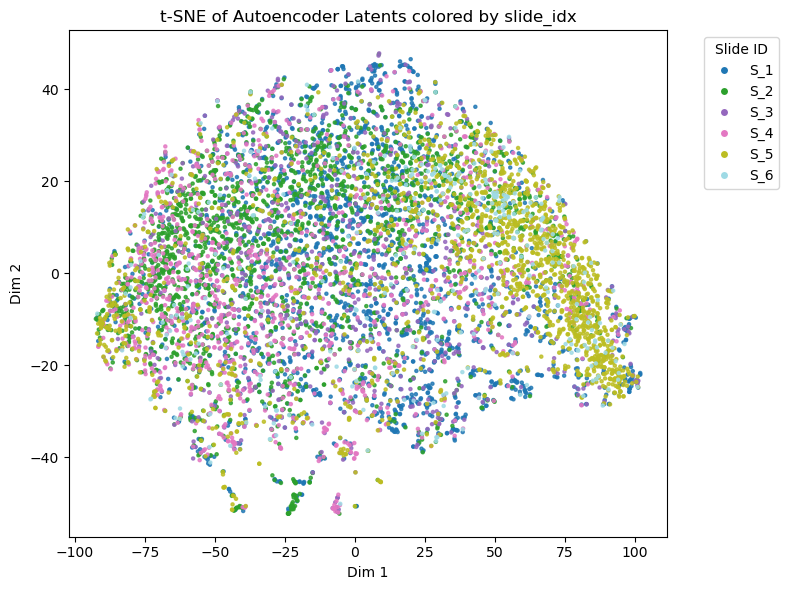

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

# latents, slide_ids 已经准备好
unique_slides, slide_codes = np.unique(slide_ids, return_inverse=True)

tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    proj[:,0], proj[:,1],
    c=slide_codes,
    cmap='tab20',
    s=5, alpha=0.8
)

# 自定义图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=scatter.cmap(scatter.norm(code)),
           markersize=6,
           label=slide_name)
    for code, slide_name in enumerate(unique_slides)
]

plt.legend(
    handles=legend_elements,
    title="Slide ID",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Autoencoder Latents colored by slide_idx")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()


# Spot 降維

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1) 定义一个简单的 Tabular Autoencoder
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim=35, latent_dim=8):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# 2) 封装 Dataset
class SpotDataset(Dataset):
    def __init__(self, matrix: np.ndarray):
        """
        matrix: shape (N_spots, 35)，预处理后的特征矩阵
        """
        self.data = torch.from_numpy(matrix).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 3) 训练函数
def train_autoencoder(
    data_matrix: np.ndarray,
    latent_dim: int = 8,
    batch_size: int = 64,
    lr: float = 1e-3,
    n_epochs: int = 50,
    device: str = "cpu"
):
    ds = SpotDataset(data_matrix)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = TabularAutoencoder(input_dim=data_matrix.shape[1], latent_dim=latent_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(1, n_epochs+1):
        model.train()
        tot_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_loss += loss.item() * batch.size(0)
        tot_loss /= len(ds)
        if epoch % 10 == 0 or epoch==1:
            print(f"Epoch {epoch}/{n_epochs}  Recon MSE: {tot_loss:.4f}")
    return model


# Data

In [82]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
#with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:

with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)
# 原始 abundance | 排名 (ordinal)
# 最大值 | 最大 rank（數字 最大）
# 最小值 | 1

# 用 "rank_" + 原本欄位名稱
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# 再和原資料合併
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)

✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6


## original_log2_z_score_rank

In [83]:

# suppose `ranked_df` has columns rank_C1…rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score = all_train_spots_df.copy()

# per‐slide zscore
# 之后再做 scaled、log2_coeff、wranks 就和之前一样
original_log2_z_score[cell_cols] = np.log2(original_log2_z_score[cell_cols])
                  
# 1) 计算每个 slide 的全局 mean & std
slide_stats = (
    original_log2_z_score
    .groupby("slide_name")[cell_cols]
    .apply(lambda sub: pd.Series({
        "slide_mean": sub.values.flatten().mean(),
        "slide_std":  sub.values.flatten().std()
    }))
    .reset_index()
)

# 2) 把这两个字段 merge 回原 df
original_log2_z_score = original_log2_z_score.merge(slide_stats, on="slide_name", how="left")

# 3) 用同一组 slide_mean/slide_std 做归一化
original_log2_z_score[cell_cols] = (original_log2_z_score[cell_cols] - original_log2_z_score["slide_mean"].values[:, None]) \
                / original_log2_z_score["slide_std"].values[:, None]

# （可选）删掉临时列
original_log2_z_score.drop(columns=["slide_mean","slide_std"], inplace=True)

original_log2_z_score[cell_cols] = original_log2_z_score[cell_cols] - original_log2_z_score[cell_cols].min().min() +1

# suppose `ranked_df` has columns rank_C1…rank_C35 plus slide_name
cell_cols = [f"C{i}" for i in range(1,36)]
original_log2_z_score_rank = original_log2_z_score.copy()
rank_cols = [f"rank_C{i}" for i in range(1,36)]
# per‐slide zscore
# 之后再做 scaled、log2_coeff、wranks 就和之前一样
# 假设 original_log2_z_score_rank 和 ranked_df 在行顺序上是对应的
orig_vals = original_log2_z_score_rank[cell_cols].to_numpy()   # shape (N,35)
rank_vals = ranked_df      [rank_cols].to_numpy()              # shape (N,35)

# 逐元素相乘
new_vals = orig_vals * rank_vals

# 赋回 DataFrame
original_log2_z_score_rank[cell_cols] = new_vals



## df_log2_ranks

In [84]:
##df_log2_ranks


cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

# 1) 计算每个 slide 的最小表达（跨所有 spots、所有 cell types）
slide_min = (
    all_train_spots_df
    .groupby('slide_name')[cell_cols]    # cell_cols = ['C1','C2',…,'C35']
    .min()                               # 得到 DataFrame: index=slide_name, columns=cell_cols
    .min(axis=1)                         # 再对 cell_cols axis=1 取最小 -> Series, index=slide_name
)

# 2) 把这个 slide 最小值映射回每一行
min_expr = (
    all_train_spots_df['slide_name']
    .map(slide_min)                      # Series 长度 N
    .values
    .reshape(-1, 1)                      # 变成 (N,1)
)



expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)
df_log2_ranks = ranked_df.copy()

# 之后再做 scaled、log2_coeff、wranks 就和之前一样
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)
wranks     = log2_coeff * ranks
# 直接替换 ranked_df 中的 rank 列
for i, col in enumerate(rank_cols):
    df_log2_ranks[col] = wranks[:, i]



## Train 

In [ ]:
# 4) 准备不同预处理的数据
#    假设 all_spots: 原始表达矩阵 shape (N,35)

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]
data_A = original_log2_z_score_rank[cell_cols].values  # raw counts or log2 etc.
data_B = df_log2_ranks[rank_cols].values  # raw counts or log2 etc.


# 5) 分别训练
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training Autoencoder on raw log2 …")
ae_A = train_autoencoder(data_A, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on per-slide min-max …")
ae_B = train_autoencoder(data_B, latent_dim=8, n_epochs=50, device=device)
print("Training Autoencoder on quantile uniform …")

# 6) 提取所有 latent 向量，做 UMAP 可视化
import umap
def get_latents(ae, data):
    with torch.no_grad():
        z = ae.encoder(torch.from_numpy(data).float().to(device))
        return z.cpu().numpy()

latents_A = get_latents(ae_A, data_A)
latents_B = get_latents(ae_B, data_B)

reducer = umap.UMAP(random_state=42)
emb_A = reducer.fit_transform(latents_A)
emb_B = reducer.fit_transform(latents_B)

# 绘图对比
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3,figsize=(12,4))
for emb, title, ax in zip([emb_A,emb_B],
                          ["raw log2","per-slide min-max","quantile"],
                          axs):
    ax.scatter(emb[:,0], emb[:,1], s=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()


Training Autoencoder on raw log2 …
Epoch 1/50  Recon MSE: 7522.9334
Epoch 10/50  Recon MSE: 1137.7520
Epoch 20/50  Recon MSE: 938.9856
Epoch 30/50  Recon MSE: 874.9552
Epoch 40/50  Recon MSE: 846.5324
Epoch 50/50  Recon MSE: 799.9916
Training Autoencoder on per-slide min-max …
Epoch 1/50  Recon MSE: 116698.3086
Epoch 10/50  Recon MSE: 16707.7757
Epoch 20/50  Recon MSE: 14942.4109
Epoch 30/50  Recon MSE: 13293.7931
Epoch 40/50  Recon MSE: 13040.7249
Epoch 50/50  Recon MSE: 12106.8598
Training Autoencoder on quantile uniform …


NameError: name 'ae_C' is not defined

In [88]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_umap_features(
    *,
    df: pd.DataFrame = None,
    latents: np.ndarray = None,
    feature_cols: list = None,
    latent_idxs: list = None,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    random_state: int = 42,
    cmap: str = "viridis",
    point_size: int = 5,
    alpha: float = 0.8,
    ncols: int = 7,
    uniform_cmap: bool = True
):
    """
    通用 UMAP 可视化：支持 DataFrame+feature_cols 或 Latent matrix+latent_idxs。

    参数:
      df           : 如果你要可视化 DataFrame 中的列，传入 df 和 feature_cols；
      latents      : 如果你直接用 latent 向量，可传 latents（N×D）和 latent_idxs（要上色的维度列表）；
      feature_cols : DataFrame 中要可视化的列名列表；
      latent_idxs  : latent 数组中要可视化的维度索引列表；
      其余参数同 plot_all_rank_umaps。
    """
    # 准备要可视化的矩阵 X 和 label arrays
    if df is not None and feature_cols is not None:
        X_in = df[feature_cols].values.astype(float)
        labels = {col: df[col].values for col in feature_cols}
        keys = feature_cols
    elif latents is not None and latent_idxs is not None:
        X_in = latents[:, latent_idxs].astype(float)
        labels = {f"latent_{i}": latents[:, i] for i in latent_idxs}
        keys = [f"latent_{i}" for i in latent_idxs]
    else:
        raise ValueError("必须传入 (df + feature_cols) 或 (latents + latent_idxs)。")

    # 1) UMAP 降维
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    emb = reducer.fit_transform(X_in)
    umap1, umap2 = emb[:,0], emb[:,1]

    # 2) 计算 Spearman ρ（UMAP1 vs 每个 feature/latent）
    rhos = []
    for k in keys:
        rho, _ = spearmanr(umap1, labels[k])
        rhos.append(abs(rho))
    avg_rho = float(np.mean(rhos))
    print(f"Average abs(Spearman rho): {avg_rho:.3f}")

    # 3) 准备色标范围
    if uniform_cmap:
        all_vals = np.vstack([labels[k] for k in keys])
        vmin, vmax = all_vals.min(), all_vals.max()
    else:
        vmin = vmax = None

    # 4) 绘制网格图
    n_plots = len(keys)
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*3, nrows*2.5),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (k, rho) in zip(axes, zip(keys, rhos)):
        sc = ax.scatter(umap1, umap2,
                        c=labels[k],
                        cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        s=point_size, alpha=alpha)
        ax.set_title(f"{k} (ρ={rho:.2f})", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

    # 删除多余子图
    for ax in axes[n_plots:]:
        ax.remove()
    plt.tight_layout()
    plt.show()

    # 5) 条形图：所有 rho 值
    rho_df = pd.DataFrame({
        "feature": keys,
        "rho": rhos
    }).set_index("feature")
    plt.figure(figsize=(ncols*0.8, nrows*0.6))
    rho_df["rho"].plot(kind="bar")
    plt.ylabel("abs(Spearman ρ)")
    plt.axhline(0, color="k", linewidth=0.5)
    plt.title("Continuity along UMAP1")
    plt.tight_layout()
    plt.show()


In [94]:
list(range(latents_A[0]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [91]:
plot_umap_features(
    latents=latents_A,      # shape (N, latent_dim)
    latent_idxs=list(range(latents_A[0])),  # 比如 [0,1,2,3,…]
    ncols=4,                # 按你的 latent_dim 调整网格
    uniform_cmap=False
)

TypeError: only integer scalar arrays can be converted to a scalar index